# Measuring VRAM

In [1]:
import torch
import os
import time
import threading
import subprocess
from contextlib import contextmanager
from pynvml import *
from time import sleep
from dataclasses import dataclass
import gc

@dataclass
class Measurement:
    allocated_start: int = None
    reserved_start: int = None
    allocated_finish: int = None
    reserved_finish: int = None
    total_start: int = None
    total_finish: int = None
    peak_allocated: int = None
    peak_reserved: int = None
    total_peak: int = None

    def __str__(self):
        return (
            f"{'':>15} | {'Start':>10} | {'Finish':>10} | {'Peak':>10}\n"
            f"{'-'*55}\n"
            f"{'Allocated':>15} | {self.allocated_start!s:>10} | {self.allocated_finish!s:>10} | {self.peak_allocated!s:>10}\n"
            f"{'Reserved':>15} | {self.reserved_start!s:>10} | {self.reserved_finish!s:>10} | {self.peak_reserved!s:>10}\n"
            f"{'Total':>15} | {self.total_start!s:>10} | {self.total_finish!s:>10} | {self.total_peak!s:>10}"
        )

@contextmanager
def monitor_gpu_memory_smi(interval=0.05, gpu_index=0):
    """
    Context manager to track:
    - PyTorch allocated & reserved (live and peak)
    - Total GPU memory used by this process (via `nvidia-smi`)
    Does NOT use pynvml.
    """
    pid = str(os.getpid())
    peak_total = [0]
    running = [True]

    def get_process_memory_mb():
        try:
            result = subprocess.run(
                ["nvidia-smi", "--query-compute-apps=pid,used_memory", "--format=csv,nounits,noheader"],
                stdout=subprocess.PIPE,
                text=True
            )
            for line in result.stdout.strip().split("\n"):
                mem = int(line.split(",")[1].strip())
                return mem
        except Exception:
            return 0
        return 0

    def poll_nvidia_smi():
        while 1:
            mem = get_process_memory_mb()
            peak_total[0] = max(peak_total[0], mem)
            if not running[0]:
                break
            time.sleep(interval)

    # Reset PyTorch memory stats
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.synchronize()

    allocated_start = torch.cuda.memory_allocated() // 1024**2
    reserved_start = torch.cuda.memory_reserved() // 1024**2
    total_start = get_process_memory_mb()

    # Start background polling thread
    thread = threading.Thread(target=poll_nvidia_smi)
    thread.start()

    measurement = Measurement()

    try:
        yield measurement
    finally:
        # Stop thread
        running[0] = False
        thread.join()
        torch.cuda.synchronize()

        # Gather PyTorch stats
        allocated_finish = torch.cuda.memory_allocated() // 1024**2
        reserved_finish = torch.cuda.memory_reserved() // 1024**2
        total_finish = get_process_memory_mb()
        peak_allocated = torch.cuda.max_memory_allocated() // 1024**2
        peak_reserved = torch.cuda.max_memory_reserved() // 1024**2
        total_peak = peak_total[0]

        # Reset PyTorch memory stats

        gc.collect()
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()
        torch.cuda.synchronize()

        measurement.allocated_start = allocated_start
        measurement.allocated_finish = allocated_finish
        measurement.peak_allocated = peak_allocated
        measurement.reserved_start = reserved_start
        measurement.reserved_finish = reserved_finish
        measurement.peak_reserved = peak_reserved
        measurement.total_start = total_start
        measurement.total_finish = total_finish
        measurement.total_peak = total_peak



In [2]:
t = torch.zeros((10000, 10000), device="cuda")
print(torch.cuda.memory_allocated(), torch.cuda.memory_reserved())
t1 = t[:5000, :].clone()
print(torch.cuda.memory_allocated(), torch.cuda.memory_reserved())
del t
print(torch.cuda.memory_allocated(), torch.cuda.memory_reserved())
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated(), torch.cuda.memory_reserved())

400556032 400556032
600556032 601882624
200000000 601882624
200000000 201326592


In [3]:
del t1
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated(), torch.cuda.memory_reserved())

0 0


### Loading and warm-up

In [4]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForCausalLM.from_pretrained("openai-community/gpt2-xl").to(device)
tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2-xl")

# Input tensor
inputs = tokenizer("This is a test sentence for measuring VRAM usage.", return_tensors="pt").to(device)

# Warmup
_ = model(**inputs)
del _

/mnt/home/surkov/conda_envs/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
m_w = torch.cuda.memory_allocated() / 1024 ** 2
m_w

6132.57861328125

In [6]:
def forward_no_grad(batch):
    with torch.no_grad():
        model(**batch)

def forward_grad(batch):
    model(**batch)


def forward_backward(batch):
    output = model(**batch).logits
    output.sum().backward()

Occupied VRAM can be divided into 3 parts
- Allocated by PyTorch
- Reserved by PyTorch but not allocated
- Occupied by not PyTorch (flash-attentions, accelerate optimizations etc.)

In [7]:
gc.collect()
batch = ["This is a test sentence for measuring VRAM usage."] * 1
batch = tokenizer(batch, return_tensors='pt').to('cuda')
for param in model.parameters():
    param.grad = None
with monitor_gpu_memory_smi(interval=0.01) as result:
    forward_backward(batch)
del batch
gc.collect()
print(result)


                |      Start |     Finish |       Peak
-------------------------------------------------------
      Allocated |       6132 |      12217 |      12832
       Reserved |       6140 |      12948 |      12948
          Total |       6640 |      13456 |      13456


In [8]:
tokenizer(["This is a test sentence for measuring VRAM usage."] * 40, return_tensors='pt').input_ids.shape

torch.Size([40, 11])

In [9]:
def experiment(batch_size, fn):
    batch = ["This is a test sentence for measuring VRAM usage."] * batch_size
    batch = tokenizer(batch, return_tensors='pt').to('cuda')
    for param in model.parameters():
        param.grad = None
    with monitor_gpu_memory_smi(interval=0.01) as measurement:
        fn(batch)
    return measurement

In [10]:
import numpy as np
batch_sizes = np.arange(3, 150, 5)
occ_no_grad = [experiment(bs, forward_no_grad) for bs in batch_sizes]
occ_grad = [experiment(bs, forward_grad) for bs in batch_sizes]
occ_back = [experiment(bs, forward_backward) for bs in batch_sizes]

In [11]:
def peak_add(measurement):
    return measurement.peak_allocated - measurement.allocated_start

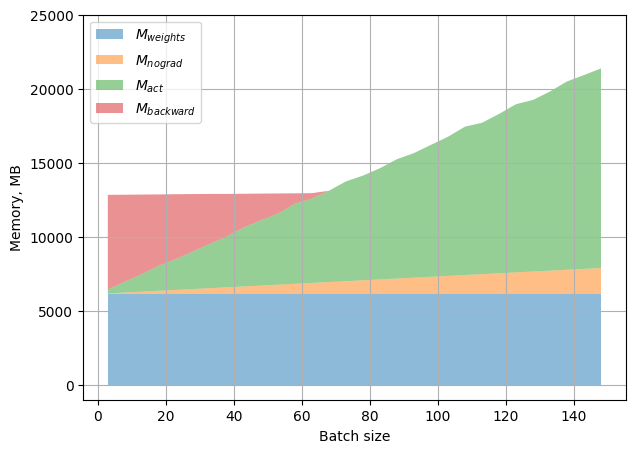

<Figure size 640x480 with 0 Axes>

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 5))
def plot_result(batch_sizes, occ_no_grad, occ_grad, occ_back):
    peak_n = np.array([peak_add(n) for n in occ_no_grad])
    peak_diff_ng = np.array([g.peak_allocated - n.peak_allocated for g, n in zip(occ_grad, occ_no_grad)])
    peak_diff_bg = np.array([b.peak_allocated - g.peak_allocated for g, b in zip(occ_grad, occ_back)])
    M_weights = occ_grad[0].allocated_start
    M_weights_plt = np.ones(len(batch_sizes)) * M_weights

    plt.fill_between(batch_sizes, np.zeros(len(batch_sizes)), M_weights_plt, label="$M_{weights}$", alpha=0.5)
    plt.fill_between(batch_sizes, M_weights_plt, M_weights_plt + peak_n, label="$M_{nograd}$", alpha=0.5)
    plt.fill_between(batch_sizes, M_weights_plt + peak_n, M_weights_plt + peak_n + peak_diff_ng, label="$M_{act}$", alpha=0.5)
    plt.fill_between(batch_sizes, M_weights_plt + peak_n + peak_diff_ng, M_weights_plt + peak_n + peak_diff_ng + peak_diff_bg, label="$M_{backward}$", alpha=0.5)
    plt.legend()
    # plt.xscale('log')
    plt.xlabel('Batch size')
    plt.ylabel('Memory, MB')
    plt.ylim(-1000, 25000)
    plt.grid()

plot_result(batch_sizes, occ_no_grad, occ_grad, occ_back)

plt.show()
plt.savefig("memory_analysis.pdf", dpi=300)

What does memory store?

Model weights + some const memory = $M_{weights}$

**no_grad_pass** = $bs \cdot \alpha_{ng} + \beta_{ng}$ (supposedly maximal activations size during forward pass)

**activations** = $bs \cdot \alpha_{act} + \beta_{act}$ (= `grad_peak - no_grad_peak`)

**backward overhead** = $bs \cdot \alpha_{b} + \beta_{b}$ (gradients + their computation overhead)

Let's calculate them

In [15]:
def linear_regression(x, y):
    if len(x) != len(y):
        raise ValueError("Input lists must have the same length.")
    
    n = len(x)
    if n == 0:
        raise ValueError("Input lists must not be empty.")

    # Calculate means
    mean_x = sum(x) / n
    mean_y = sum(y) / n

    # Calculate coefficients
    numerator = sum((x[i] - mean_x) * (y[i] - mean_y) for i in range(n))
    denominator = sum((x[i] - mean_x) ** 2 for i in range(n))
    
    if denominator == 0:
        raise ValueError("Denominator is zero, cannot compute slope (maybe all x are the same).")

    slope = numerator / denominator
    intercept = mean_y - slope * mean_x

    return slope, intercept

In [16]:
M_weights = m_w
alpha_ng, beta_ng = linear_regression(batch_sizes, [peak_add(n) for n in occ_no_grad])
alpha_act, beta_act = linear_regression(batch_sizes, [peak_add(g) - peak_add(n) for n, g in zip(occ_no_grad, occ_grad)])
alpha_b, beta_b = linear_regression(batch_sizes[1:], [peak_add(b) - peak_add(g) for g, b in zip(occ_grad, occ_back)][1:])

from IPython.display import display, Math
display(Math(f"M_\\text{{weights}} = {M_weights}"))

display(Math(f"\\text{{No Grad: }}\\quad \\text{{peak}}(B) = {alpha_ng:.2f} \\cdot B + {beta_ng:.2f}"))
display(Math(f"\\text{{Activation: }}\\quad \\text{{peak}}(B) = {alpha_act:.2f} \\cdot B + {beta_act:.2f}"))
display(Math(f"\\text{{Backward: }}\\quad \\text{{peak}}(B) = {alpha_b:.2f} \\cdot B + {beta_b:.2f}"))

NameError: name 'm_w' is not defined

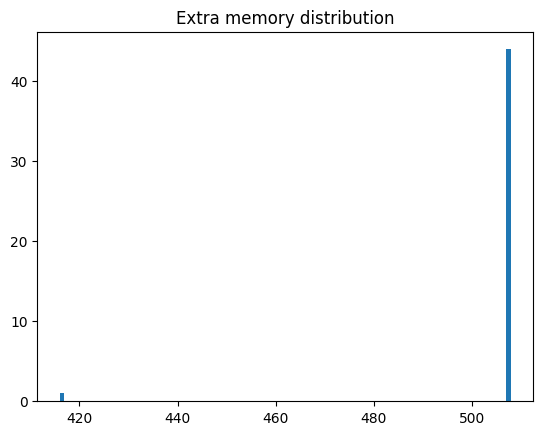

In [19]:
all_total_res_diff = []
for collection in occ_no_grad, occ_grad, occ_back:
    for measurement in collection:
        all_total_res_diff.append(measurement.total_peak - measurement.peak_reserved)

plt.title("Extra memory distribution")
plt.hist(all_total_res_diff, bins=100)
plt.show()

In [14]:
from peft import LoraConfig, get_peft_model, TaskType

lora_config = LoraConfig(
    r=8,  # rank of the low-rank matrices
    lora_alpha=32,
    target_modules=["c_attn", "c_proj"],  # depends on model architecture
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.CAUSAL_LM  # or SEQ_CLS, TOKEN_CLS, etc.
)

model = get_peft_model(model, lora_config)

/mnt/home/surkov/conda_envs/venv/lib/python3.10/site-packages/peft/tuners/lora/layer.py:1264: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [15]:
def forward_no_grad(batch):
    with torch.no_grad():
        model(**batch)

def forward_grad(batch):
    model(**batch)


def forward_backward(batch):
    output = model(**batch).logits
    output.sum().backward()

In [16]:
import numpy as np
occ_no_grad_lora = [experiment(bs, forward_no_grad) for bs in batch_sizes]
occ_grad_lora = [experiment(bs, forward_grad) for bs in batch_sizes]
occ_back_lora = [experiment(bs, forward_backward) for bs in batch_sizes]

In [ ]:
pl

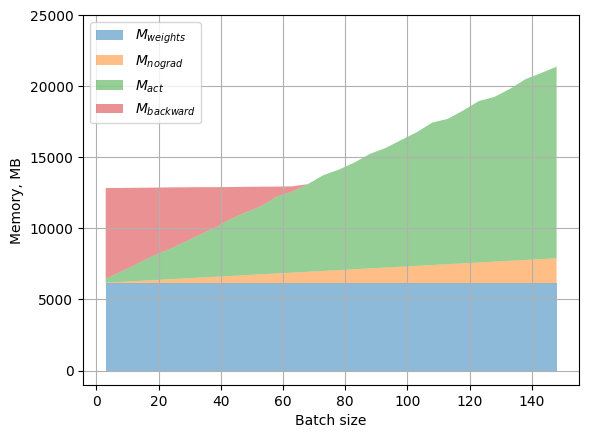

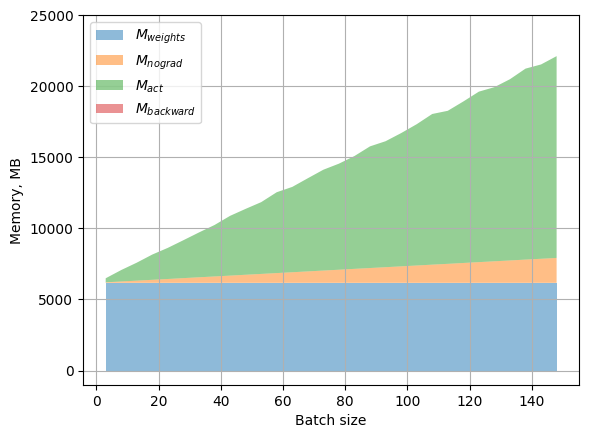

In [27]:
plot_result(batch_sizes, occ_no_grad, occ_grad, occ_back)
plt.savefig("memory_analysis.pdf", dpi=300)
plt.show()
plot_result(batch_sizes, occ_no_grad_lora, occ_grad_lora, occ_back_lora)
plt.savefig("memory_analysis_lora.pdf", dpi=300)
plt.show()

In [ ]:
M_weights = occ_grad[0].allocated_start
alpha_ng, beta_ng = linear_regression(batch_sizes, [n.peak_allocated - n.allocated_start for n in occ_no_grad])
alpha_act, beta_act = linear_regression(batch_sizes, [g.peak_allocated - n.peak_allocated for n, g in zip(occ_no_grad, occ_grad)])
alpha_b, beta_b = linear_regression(batch_sizes[1:], [b.peak_allocated - g.peak_allocated for g, b in zip(occ_grad, occ_back)][1:])

from IPython.display import display, Math
display(Math(f"M_\\text{{weights}} = {M_weights}"))

display(Math(f"\\text{{No Grad: }}\\quad \\text{{peak}}(B) = {alpha_ng:.2f} \\cdot B + {beta_ng:.2f}"))
display(Math(f"\\text{{Activation: }}\\quad \\text{{peak}}(B) = {alpha_act:.2f} \\cdot B + {beta_act:.2f}"))
display(Math(f"\\text{{Backward: }}\\quad \\text{{peak}}(B) = {alpha_b:.2f} \\cdot B + {beta_b:.2f}"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>